In [1]:
import torch
import os

In [2]:
#only in google colab
!git clone https://github.com/Giordano-Cicchetti/MaskTune_NN/

Cloning into 'MaskTune_NN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 111 (delta 47), reused 66 (delta 28), pack-reused 0
Receiving objects: 100% (111/111), 4.38 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
#only on google colab
!cp MaskTune_NN/MNIST/* /content -r
!rm MaskTune_NN/ -r

cp: cannot stat 'MaskTune_NN/MNIST/*': No such file or directory
rm: cannot remove 'MaskTune_NN/': No such file or directory


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from train import *
train= TrainBaseERM(device)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/BiasedMNIST/raw/train-images-idx3-ubyte.gz to data/BiasedMNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/BiasedMNIST/raw/train-labels-idx1-ubyte.gz to data/BiasedMNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/BiasedMNIST/raw/t10k-images-idx3-ubyte.gz to data/BiasedMNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/BiasedMNIST/raw/t10k-labels-idx1-ubyte.gz to data/BiasedMNIST/raw



start creating and saving train dataset of BiasedMnist




Start loading data of train dataset in main memory




start creating and saving test dataset of BiasedMnist




Start loading data of test dataset in main memory




start creating and saving test dataset of BiasedMnist




Start loading data of test dataset in main memory




In [28]:
train.train_dataset.targets[0:15]

tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])

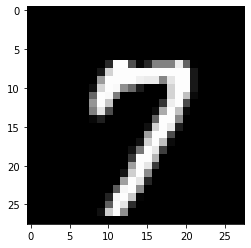

In [35]:
import matplotlib.pyplot as plt
plt.imshow(train.train_dataset[7][0].transpose(0,1).transpose(1,2))

In [48]:
train.train_erm(epochs=10)

validation epoch 0: 100%|██████████| 94/94 [00:01<00:00, 47.78it/s, loss=0.0127, accuracy=0.997]


lr: 0.01


validation epoch 1: 100%|██████████| 94/94 [00:01<00:00, 47.67it/s, loss=0.00994, accuracy=0.997]


lr: 0.01


validation epoch 2: 100%|██████████| 94/94 [00:01<00:00, 48.27it/s, loss=0.00753, accuracy=0.998]


lr: 0.01


validation epoch 3: 100%|██████████| 94/94 [00:01<00:00, 48.14it/s, loss=0.00715, accuracy=0.998]


lr: 0.01


validation epoch 4: 100%|██████████| 94/94 [00:02<00:00, 46.22it/s, loss=0.00635, accuracy=0.998]


lr: 0.01


validation epoch 5: 100%|██████████| 94/94 [00:01<00:00, 47.76it/s, loss=0.00544, accuracy=0.998]


lr: 0.01


validation epoch 6: 100%|██████████| 94/94 [00:01<00:00, 48.03it/s, loss=0.00555, accuracy=0.998]


lr: 0.01


validation epoch 7: 100%|██████████| 94/94 [00:01<00:00, 48.29it/s, loss=0.00574, accuracy=0.998]


lr: 0.01


validation epoch 8: 100%|██████████| 94/94 [00:01<00:00, 48.10it/s, loss=0.00574, accuracy=0.998]


lr: 0.01


validation epoch 9: 100%|██████████| 94/94 [00:01<00:00, 48.41it/s, loss=0.00526, accuracy=0.998]


lr: 0.01


In [ ]:
train.train_erm(resume=True,best_resume_checkpoint_path="best_erm_model.pt",last_resume_checkpoint_path="last_erm_model.pt")

In [36]:
train.test(train.test_loader_original,"best_erm_model.pt")

----------testing the model----------


test epoch 12: 100%|██████████| 79/79 [00:03<00:00, 21.87it/s, loss=2.72, accuracy=0.594]

----------Test accuracy =0.5941455696202531----------


In [37]:
train.test(train.test_loader_biased,"best_erm_model.pt")

----------testing the model----------


test epoch 12: 100%|██████████| 79/79 [00:01<00:00, 49.08it/s, loss=4.25, accuracy=0.31]


----------Test accuracy =0.30963212025316456----------


In [11]:
!rm data -r

In [7]:
def finetune(best_resume_checkpoint_path: str=None, last_resume_checkpoint_path: str=None) -> None:
  checkpoint = torch.load("last_erm_model.pt")

  if(best_resume_checkpoint_path!=None and last_resume_checkpoint_path!=None):
    train.mask_data(train.train_loader,best_resume_checkpoint_path)
    train.model.load_state_dict(checkpoint['model_state_dict'])
    train.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train.lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    resume_epoch = checkpoint['epoch'] + 1


    train.run_an_epoch(data_loader=train.masked_loader,epoch=resume_epoch,mode="train",device=train.device)
    val_accuracy = train.run_an_epoch(
        data_loader=train.val_loader, epoch=resume_epoch, mode="validation",device=train.device
    )
    torch.save({
                'epoch': resume_epoch,
                'model_state_dict': train.model.state_dict(),
                'optimizer_state_dict': train.optimizer.state_dict(),
                'scheduler_state_dict': train.lr_scheduler.state_dict(),
                'accuracy' : val_accuracy,
                }, "masked_erm_model.pt")
    

finetune(best_resume_checkpoint_path="best_erm_model.pt",last_resume_checkpoint_path="last_erm_model.pt")


validation epoch 10: 100%|██████████| 94/94 [00:01<00:00, 47.29it/s, loss=0.00388, accuracy=0.999]


In [8]:
train.test(train.test_loader_original,"masked_erm_model.pt")

----------testing the model----------


test epoch 10: 100%|██████████| 79/79 [00:01<00:00, 47.37it/s, loss=1.05, accuracy=0.694]

----------Test accuracy =0.6942246835443038----------


In [9]:
train.test(train.test_loader_biased,"masked_erm_model.pt")

----------testing the model----------


test epoch 10: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s, loss=2.07, accuracy=0.436]

----------Test accuracy =0.4363132911392405----------
